# 03 - MST Clinical analysis

This notebook investigates relationships between changes in spectral features of scalp EEG and clinical severity ratings for patients undergoing MST for treatment resistant depression. 

Symptom severity is assesssed with the HAMD-24 rating scale.

## imports

In [1]:
import numpy as np
import scipy.io as sio
import pandas as pd
import h5py as h5

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.formula.api import ols
from pingouin import corr, ttest

from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn import linear_model

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.0, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


## load EEG features

This cell loads the dataframe with the outputs of the spectral parameterization analysis. Features are then averaged over all electrodes. We are averaging over all electrodes because no spectral features of interest show a characteristic, informative spatial topography. Futhermore, model fits <0.8 are dropped due to poor models fits.

In [2]:
# load dataframe of EEG features
eeg_df = pd.read_csv('../saved_files_appeal/mst_files/mst_all_features.csv', index_col = 0)

# Exclude channels flagged as bad fits
eeg_df_included = eeg_df[eeg_df['exclude']==False]

# features to include in analysis
features = ['delta_cf', 'delta_bw', 'delta_amp', 'delta_bp', 'theta_cf', 'theta_bw', 'theta_amp',
            'theta_bp', 'alpha_cf', 'alpha_bw', 'alpha_amp', 'alpha_bp', 'offset', 'exponent']

# exclude bad fits
eeg_df_included = eeg_df[eeg_df['exclude']==False]

# average across ALL electrodes
eeg_df_mean = pd.DataFrame(eeg_df_included.groupby(['patient', 'pre_post'], as_index=False)[features].mean())

In [3]:
def compute_abundance(df, feature=''):
    """computes abundance as the number of channels containing an oscillation/total channels
    Parameters
    ----------
    Returns
    -------
    """
    features = ['patient','pre_post','channel', feature+'_cf']
    df_osc = pd.DataFrame(df[features])
    df_osc[f'{feature}_present'] = df_osc[feature+'_cf'].notna()
    ch_osc = df_osc.groupby(['patient', 'pre_post'])[f'{feature}_present'].sum().values
    ch_total = df_osc.groupby(['patient', 'pre_post'])['channel'].count().values
    ch_osc_perc = ch_osc/ch_total
    osc_perc_df = pd.DataFrame(df_osc.groupby(['patient', 'pre_post'], as_index=False)[f'{feature}_present'].sum())
    osc_perc_df[f'ch_{feature}_perc'] = ch_osc_perc
    
    return osc_perc_df

In [4]:
delta_perc_df = compute_abundance(eeg_df_included, feature='delta')
theta_perc_df = compute_abundance(eeg_df_included, feature='theta')
alpha_perc_df = compute_abundance(eeg_df_included, feature='alpha')

In [5]:
# merge percentage dfs
perc_df = pd.merge(theta_perc_df, delta_perc_df, how='left', on=['patient', 'pre_post'])
perc_df = pd.merge(perc_df, alpha_perc_df, how='left', on=['patient', 'pre_post'])

In [6]:
# merge perc with main eeg feature df
eeg_df_mean = pd.merge(eeg_df_mean, perc_df, how='left', on=['patient', 'pre_post'])

## convert EEG features dataframe into better format

The ideal dataframe for our analysis has one line for each patient. EEG features are either pre_feature, post_feature, or d_feature.

In [7]:
# pre eeg features
eeg_pre_df_mean = eeg_df_mean[eeg_df_mean['pre_post']=='pre'] 

# post eeg features
eeg_post_df_mean = eeg_df_mean[eeg_df_mean['pre_post']=='post'] 

features = ['delta_cf', 'delta_bw', 'delta_amp', 'delta_bp', 'theta_cf', 'theta_bw', 'theta_amp',
            'theta_bp', 'alpha_cf', 'alpha_bw', 'alpha_amp', 'alpha_bp', 'offset', 'exponent',
            'ch_delta_perc', 'ch_theta_perc', 'ch_alpha_perc']

# difference in eeg features (pre-post)
eeg_diff_df_mean = eeg_df_mean.groupby(['patient'], as_index=False)[features].diff().dropna(0,how='all')
eeg_diff_df_mean['patient'] = eeg_df_mean['patient']

/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_67390/668889714.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  eeg_diff_df_mean = eeg_df_mean.groupby(['patient'], as_index=False)[features].diff().dropna(0,how='all')


In [8]:
eeg_pre_df_mean = eeg_pre_df_mean.rename(columns={c: 'pre_'+c for c in eeg_pre_df_mean.columns if c not in ['patient']})
eeg_post_df_mean = eeg_post_df_mean.rename(columns={c: 'post_'+c for c in eeg_post_df_mean.columns if c not in ['patient']})
eeg_diff_df_mean = eeg_diff_df_mean.rename(columns={c: 'diff_'+c for c in eeg_diff_df_mean.columns if c not in ['patient']})


In [9]:
eeg_pre_post = pd.merge(eeg_pre_df_mean, eeg_post_df_mean, on='patient', how='left')
eeg_pre_post_diff = pd.merge(eeg_pre_post, eeg_diff_df_mean, on='patient', how='left')

In [10]:
eeg_pre_post_diff = eeg_pre_post_diff.drop(labels=['pre_pre_post', 'post_pre_post'], axis='columns')

In [11]:
eeg_pre_post_diff

,patient,pre_delta_cf,pre_delta_bw,pre_delta_amp,pre_delta_bp,pre_theta_cf,pre_theta_bw,pre_theta_amp,pre_theta_bp,pre_alpha_cf,...,diff_theta_bp,diff_alpha_cf,diff_alpha_bw,diff_alpha_amp,diff_alpha_bp,diff_offset,diff_exponent,diff_ch_delta_perc,diff_ch_theta_perc,diff_ch_alpha_perc
0,9,2.005953,1.000000,0.146205,-11.321277,5.350125,1.818249,0.406346,-11.572985,9.112030,...,0.217771,-0.192200,1.119524,-0.033322,0.237228,0.507025,0.345650,0.033333,-0.416667,0.000000
1,10,2.453152,1.000000,0.040532,-12.365095,6.482045,1.017572,0.186566,-12.690452,9.555304,...,0.271554,-0.243517,0.389320,0.133247,0.377337,0.261876,0.025480,0.017857,0.071429,0.125000
2,18,2.749999,1.000000,0.000270,-11.664588,5.256693,1.425727,0.347283,-11.836585,8.734414,...,0.134673,-0.024780,0.562352,0.012112,-0.016471,0.042335,0.115917,0.000000,0.266667,0.000000
3,22,NaN,NaN,NaN,-11.830947,6.542572,2.014467,0.452602,-11.993586,9.135260,...,-0.450002,0.006089,-1.981499,0.285625,-0.103030,-0.369752,-0.184502,0.000000,0.000000,0.000000
4,25,NaN,NaN,NaN,-11.694787,6.619938,1.421509,0.362230,-12.026519,8.687937,...,0.323614,-0.800650,-0.613174,-0.779568,-0.284728,0.466595,0.014182,-0.033898,0.118644,0.000000
5,33,NaN,NaN,NaN,-11.528993,5.631176,1.607905,0.454667,-11.381208,8.937167,...,-0.488498,0.058184,-0.219198,0.204019,0.044466,-0.526216,-0.494473,-0.133333,-0.266667,0.000000
6,35,3.937715,1.000000,0.201216,-11.883628,5.972226,2.172916,0.579893,-11.723036,7.923002,...,-0.371153,-0.089036,0.994337,0.103503,0.007112,-0.224031,-0.138135,0.066667,-0.583333,0.466667
7,46,NaN,NaN,NaN,-11.726602,4.630958,1.658109,0.392234,-11.773041,9.020745,...,-0.025370,-0.023627,-0.105915,0.087367,0.072388,-0.005157,-0.036711,0.000000,-0.116667,0.000000
8,47,3.012010,1.184911,0.202836,-11.998070,5.407184,2.042564,0.173121,-12.393061,8.833356,...,0.344395,-0.626846,0.838933,-0.289977,0.098429,0.266258,0.144388,0.183333,0.033333,0.000000
9,53,2.605767,1.000000,0.055501,-11.787089,6.301462,1.015626,0.313621,-12.095150,9.218807,...,-0.245605,-0.093968,-0.468883,-0.235628,-0.237180,-0.002819,0.032645,-0.016667,0.100000,0.000000


## load clinical features CSV

This cell loads the dataframes with clinical ratings and demographics. These dataframes are then refactored into a single clinical dataframe with the relevant features included.

In [12]:
MST_clinical = pd.read_csv('../saved_files_appeal/mst_files/mst_clinical_data/MST_clinical.csv')
MST_HAMD = pd.read_csv('../saved_files_appeal/mst_files/mst_clinical_data/MST_HAMD.csv')
exp_df = pd.read_csv('../saved_files_appeal/mst_files/mst_all_features.csv', index_col=0)

# rename columns

MST_HAMD = MST_HAMD[['subject', 'TotalBaseline', 'TotalPost']].copy().rename(columns={'subject': 'patient',
                                                                                 'TotalBaseline': 'pre_HAMD',
                                                                                 'TotalPost': 'post_HAMD'})
MST_clinical = MST_clinical[['SubjectID', 'x_OfAcuteTxsReceived']].copy().rename(columns={'SubjectID': 'patient',
                                                                                   'x_OfAcuteTxsReceived': 'n_TxsReceived'})

# merge into single dataframe
all_clinical = pd.merge(MST_HAMD, MST_clinical, on='patient', how='outer')

## note about merging clinical and EEG data

Merge dataframes at an ad-hoc basis for the demands of each regression formula 

In [13]:
clin_eeg_df = pd.merge(eeg_pre_post_diff, all_clinical, on='patient', how='left')

In [14]:
clin_eeg_df

,patient,pre_delta_cf,pre_delta_bw,pre_delta_amp,pre_delta_bp,pre_theta_cf,pre_theta_bw,pre_theta_amp,pre_theta_bp,pre_alpha_cf,...,diff_alpha_amp,diff_alpha_bp,diff_offset,diff_exponent,diff_ch_delta_perc,diff_ch_theta_perc,diff_ch_alpha_perc,pre_HAMD,post_HAMD,n_TxsReceived
0,9,2.005953,1.000000,0.146205,-11.321277,5.350125,1.818249,0.406346,-11.572985,9.112030,...,-0.033322,0.237228,0.507025,0.345650,0.033333,-0.416667,0.000000,23,19.0,24
1,10,2.453152,1.000000,0.040532,-12.365095,6.482045,1.017572,0.186566,-12.690452,9.555304,...,0.133247,0.377337,0.261876,0.025480,0.017857,0.071429,0.125000,28,NaN,18
2,18,2.749999,1.000000,0.000270,-11.664588,5.256693,1.425727,0.347283,-11.836585,8.734414,...,0.012112,-0.016471,0.042335,0.115917,0.000000,0.266667,0.000000,24,27.0,24
3,22,NaN,NaN,NaN,-11.830947,6.542572,2.014467,0.452602,-11.993586,9.135260,...,0.285625,-0.103030,-0.369752,-0.184502,0.000000,0.000000,0.000000,22,NaN,6
4,25,NaN,NaN,NaN,-11.694787,6.619938,1.421509,0.362230,-12.026519,8.687937,...,-0.779568,-0.284728,0.466595,0.014182,-0.033898,0.118644,0.000000,34,NaN,21
5,33,NaN,NaN,NaN,-11.528993,5.631176,1.607905,0.454667,-11.381208,8.937167,...,0.204019,0.044466,-0.526216,-0.494473,-0.133333,-0.266667,0.000000,26,19.0,24
6,35,3.937715,1.000000,0.201216,-11.883628,5.972226,2.172916,0.579893,-11.723036,7.923002,...,0.103503,0.007112,-0.224031,-0.138135,0.066667,-0.583333,0.466667,29,NaN,6
7,46,NaN,NaN,NaN,-11.726602,4.630958,1.658109,0.392234,-11.773041,9.020745,...,0.087367,0.072388,-0.005157,-0.036711,0.000000,-0.116667,0.000000,29,21.0,24
8,47,3.012010,1.184911,0.202836,-11.998070,5.407184,2.042564,0.173121,-12.393061,8.833356,...,-0.289977,0.098429,0.266258,0.144388,0.183333,0.033333,0.000000,41,31.0,24
9,53,2.605767,1.000000,0.055501,-11.787089,6.301462,1.015626,0.313621,-12.095150,9.218807,...,-0.235628,-0.237180,-0.002819,0.032645,-0.016667,0.100000,0.000000,33,NaN,18


In [15]:
features = ['pre_delta_amp', 'pre_theta_amp', 'pre_alpha_amp', 'pre_exponent', 'pre_ch_delta_perc',
            'diff_delta_amp', 'diff_theta_amp', 'diff_alpha_amp', 'diff_exponent',
            'diff_ch_delta_perc', 'diff_ch_theta_perc', 'diff_ch_alpha_perc', 
            'pre_HAMD', 'post_HAMD', 'n_TxsReceived']

<AxesSubplot:>

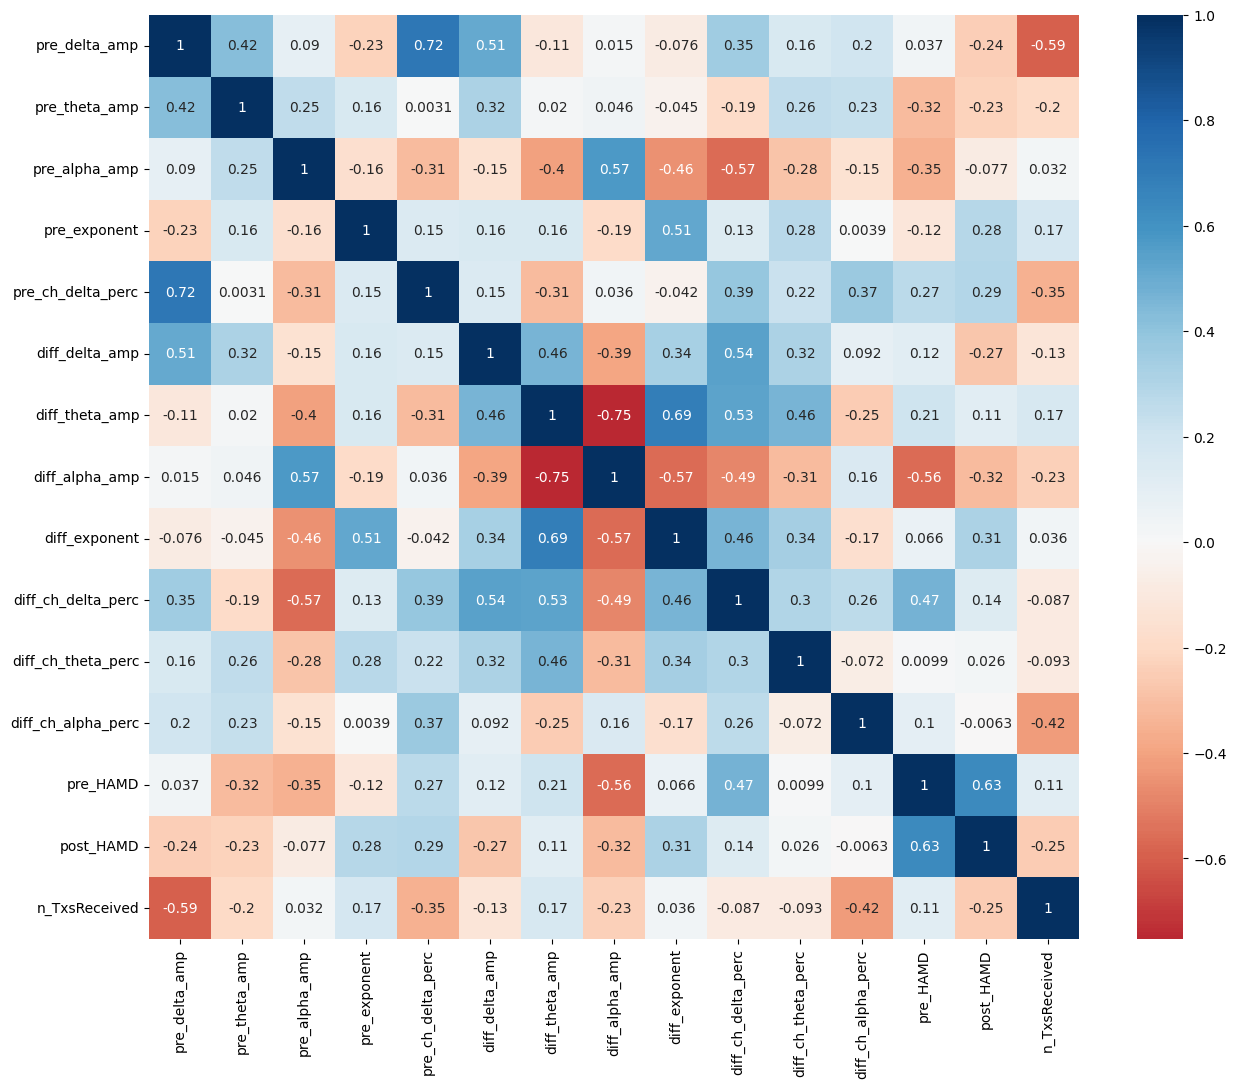

In [16]:
plt.figure(figsize=[15,12])
sns.heatmap(clin_eeg_df[features].corr(), cmap='RdBu', center=0, annot=True)

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


,n,r,CI95%,p-val,BF10,power
pearson,22,-0.421777,"[-0.72, -0.0]",0.050564,1.594,0.515513


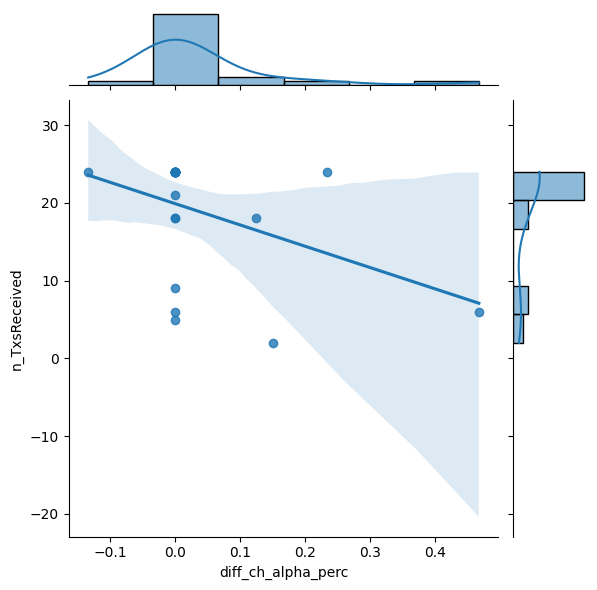

In [17]:
x = clin_eeg_df['diff_ch_alpha_perc']
y = clin_eeg_df['n_TxsReceived']

sns.jointplot(x, y, kind="reg")

corr(x,y)

# Stepwise Linear Regression

Working backwards, remove features from the multiple linear regression model in order to best predict the outcome of treatment. We will do 3 different versions. 

1) final HAMD with baseline as a feature `post_HAMD ~ pre_HAMD + feature_1 + .... + feature_n`  
2) HAMD difference `pre_HAMD - post_HAMD ~ feature_1 + .... + feature_n`  
3) HAMD ratio `(pre_HAMD - post_HAMD)/pre_HAMD ~ feature_1 + .... + feature_n`  


Here is an exhaustive list of the features to be included in the model, not to exceed 15, due to number of subjects:

n = 14  
`'pre_delta_amp', 'pre_theta_amp', 'pre_alpha_amp', 'pre_exponent', 'pre_ch_delta_perc', 
'diff_delta_amp', 'diff_theta_amp', 'diff_alpha_amp', 'diff_exponent',
'diff_ch_delta_perc', 'diff_ch_theta_perc', 'diff_ch_alpha_perc', 
'pre_HAMD', 'n_TxsReceived'`

The following interaction terms should also be considered because their correlation coefficients are greater than 0.4:

n = 20  
`'pre_delta_amp:pre_theta_amp', '*pre_delta_amp:pre_ch_delta_perc', 'pre_delta_amp:diff_delta_amp', 
'*pre_delta_amp:n_TxsReceived', 'pre_alpha_amp:diff_theta_amp', '*diff_alpha_amp:pre_alpha_amp',
'*pre_alpha_amp:diff_ch_delta_perc', '*pre_exponent:diff_exponent', 'diff_delta_amp:diff_theta_amp',
'diff_delta_amp:diff_ch_delta_perc', '*diff_theta_amp:diff_alpha_amp', '*diff_theta_amp:diff_exponent',
'*diff_theta_amp:diff_ch_delta_perc', '*diff_theta_amp:diff_ch_theta_perc', '*diff_alpha_amp:diff_exponent',
'*diff_alpha_amp:diff_ch_delta_perc', '*diff_alpha_amp:pre_HAMD', '*diff_exponent:diff_ch_delta_perc',
'*diff_ch_delta_perc:pre_HAMD', '*diff_ch_alpha_perc:n_TxsReceived'`

Correlations that are significant or trending are *

Note: In selecting model parameters, alpha features are excluded because they do not align to slowing hypotheses. This also helps to keep counts down. Features with incomplete datasets (i.e. delta amps, theta amps) were also excluded because there were too few observations. 

## 1) Final HAMD w/ baseline as a feature

no interactions first

In [18]:
formula = 'post_HAMD  ~ pre_HAMD + pre_exponent + pre_ch_delta_perc + pre_ch_theta_perc + pre_alpha_amp + \
           diff_exponent + diff_ch_delta_perc + diff_ch_theta_perc + diff_alpha_amp + n_TxsReceived'
           

model = ols(formula, clin_eeg_df).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              post_HAMD   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                     11.89
Date:                Tue, 27 Jun 2023   Prob (F-statistic):             0.0328
Time:                        11:23:26   Log-Likelihood:                -22.351
No. Observations:                  14   AIC:                             66.70
Df Residuals:                       3   BIC:                             73.73
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            -26.0725      9

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [19]:
# remove pre_alpha_amp

formula = 'post_HAMD  ~ pre_HAMD + pre_exponent + pre_ch_delta_perc + pre_ch_theta_perc + \
           diff_exponent + diff_ch_delta_perc + diff_ch_theta_perc + diff_alpha_amp + n_TxsReceived'
           

model = ols(formula, clin_eeg_df).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              post_HAMD   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     12.53
Date:                Tue, 27 Jun 2023   Prob (F-statistic):             0.0134
Time:                        11:23:26   Log-Likelihood:                -24.668
No. Observations:                  14   AIC:                             69.34
Df Residuals:                       4   BIC:                             75.73
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            -22.0741      8

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [20]:
# remove pre_alpha_amp

formula = 'post_HAMD  ~ pre_HAMD + pre_exponent + pre_ch_delta_perc + pre_ch_theta_perc + \
           diff_exponent + diff_ch_delta_perc + diff_ch_theta_perc + diff_alpha_amp + n_TxsReceived'
           

model = ols(formula, clin_eeg_df).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              post_HAMD   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     12.53
Date:                Tue, 27 Jun 2023   Prob (F-statistic):             0.0134
Time:                        11:23:26   Log-Likelihood:                -24.668
No. Observations:                  14   AIC:                             69.34
Df Residuals:                       4   BIC:                             75.73
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            -22.0741      8

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [21]:
# remove diff_alpha_amp

formula = 'post_HAMD  ~ pre_HAMD + pre_exponent + pre_ch_delta_perc + pre_ch_theta_perc + \
           diff_exponent + diff_ch_delta_perc + diff_ch_theta_perc + n_TxsReceived'
           

model = ols(formula, clin_eeg_df).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              post_HAMD   R-squared:                       0.947
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     11.15
Date:                Tue, 27 Jun 2023   Prob (F-statistic):            0.00835
Time:                        11:23:26   Log-Likelihood:                -27.733
No. Observations:                  14   AIC:                             73.47
Df Residuals:                       5   BIC:                             79.22
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            -17.6541      9

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [22]:
# remove diff_exponent

formula = 'post_HAMD  ~ pre_HAMD + pre_exponent + pre_ch_delta_perc + pre_ch_theta_perc + \
           diff_ch_delta_perc + diff_ch_theta_perc + n_TxsReceived'
           

model = ols(formula, clin_eeg_df).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              post_HAMD   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     11.08
Date:                Tue, 27 Jun 2023   Prob (F-statistic):            0.00465
Time:                        11:23:26   Log-Likelihood:                -29.848
No. Observations:                  14   AIC:                             75.70
Df Residuals:                       6   BIC:                             80.81
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            -20.5261      9

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [23]:
# remove pre_ch_theta_perc

formula = 'post_HAMD  ~ pre_HAMD + pre_exponent + pre_ch_delta_perc + \
           diff_ch_delta_perc + diff_ch_theta_perc + n_TxsReceived'
           

model = ols(formula, clin_eeg_df).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              post_HAMD   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.747
Method:                 Least Squares   F-statistic:                     7.411
Date:                Tue, 27 Jun 2023   Prob (F-statistic):            0.00919
Time:                        11:23:26   Log-Likelihood:                -34.320
No. Observations:                  14   AIC:                             82.64
Df Residuals:                       7   BIC:                             87.11
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            -27.2601     11

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [24]:
# remove diff_ch_theta_perc

formula = 'post_HAMD  ~ pre_HAMD + pre_exponent + pre_ch_delta_perc + \
           diff_ch_delta_perc + n_TxsReceived'
           

model = ols(formula, clin_eeg_df).fit()

print(model.summary())

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


                            OLS Regression Results                            
Dep. Variable:              post_HAMD   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.731
Method:                 Least Squares   F-statistic:                     8.056
Date:                Tue, 27 Jun 2023   Prob (F-statistic):            0.00550
Time:                        11:23:26   Log-Likelihood:                -35.702
No. Observations:                  14   AIC:                             83.40
Df Residuals:                       8   BIC:                             87.24
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            -28.2156     11

In [25]:
# remove pre_ch_delta_perc

formula = 'post_HAMD  ~ pre_HAMD + pre_exponent + \
           diff_ch_delta_perc + n_TxsReceived'
           

model = ols(formula, clin_eeg_df).fit()

print(model.summary())

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


                            OLS Regression Results                            
Dep. Variable:              post_HAMD   R-squared:                       0.788
Model:                            OLS   Adj. R-squared:                  0.693
Method:                 Least Squares   F-statistic:                     8.349
Date:                Tue, 27 Jun 2023   Prob (F-statistic):            0.00425
Time:                        11:23:26   Log-Likelihood:                -37.437
No. Observations:                  14   AIC:                             84.87
Df Residuals:                       9   BIC:                             88.07
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            -19.6741     11

In [26]:
# remove n_TxsReceived

formula = 'post_HAMD  ~ pre_HAMD + pre_exponent + \
           diff_ch_delta_perc'
           

model = ols(formula, clin_eeg_df).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              post_HAMD   R-squared:                       0.645
Model:                            OLS   Adj. R-squared:                  0.538
Method:                 Least Squares   F-statistic:                     6.044
Date:                Tue, 27 Jun 2023   Prob (F-statistic):             0.0129
Time:                        11:23:26   Log-Likelihood:                -41.046
No. Observations:                  14   AIC:                             90.09
Df Residuals:                      10   BIC:                             92.65
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            -28.5848     12

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [27]:
# remove diff_ch_delta_perc

formula = 'post_HAMD  ~ pre_HAMD + pre_exponent'
           

model = ols(formula, clin_eeg_df).fit()

print(model.summary())

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


                            OLS Regression Results                            
Dep. Variable:              post_HAMD   R-squared:                       0.501
Model:                            OLS   Adj. R-squared:                  0.410
Method:                 Least Squares   F-statistic:                     5.515
Date:                Tue, 27 Jun 2023   Prob (F-statistic):             0.0219
Time:                        11:23:26   Log-Likelihood:                -43.425
No. Observations:                  14   AIC:                             92.85
Df Residuals:                      11   BIC:                             94.77
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      -13.2059     11.731     -1.126   

In [28]:
# remove pre_exponent

formula = 'post_HAMD  ~ pre_HAMD'
           

model = ols(formula, clin_eeg_df).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              post_HAMD   R-squared:                       0.401
Model:                            OLS   Adj. R-squared:                  0.351
Method:                 Least Squares   F-statistic:                     8.027
Date:                Tue, 27 Jun 2023   Prob (F-statistic):             0.0151
Time:                        11:23:26   Log-Likelihood:                -44.701
No. Observations:                  14   AIC:                             93.40
Df Residuals:                      12   BIC:                             94.68
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0242      7.990      0.003      0.9

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


# 2) Difference in HAMD

In [29]:
formula = 'post_HAMD - pre_HAMD ~ pre_exponent + pre_ch_delta_perc + pre_ch_theta_perc + \
           diff_exponent + diff_ch_delta_perc + diff_ch_theta_perc + n_TxsReceived + \
           pre_exponent:diff_exponent + diff_exponent:diff_ch_delta_perc'
           

model = ols(formula, clin_eeg_df).fit()

print(model.summary())

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


                            OLS Regression Results                            
Dep. Variable:              post_HAMD   R-squared:                       0.659
Model:                            OLS   Adj. R-squared:                 -0.109
Method:                 Least Squares   F-statistic:                    0.8581
Date:                Tue, 27 Jun 2023   Prob (F-statistic):              0.612
Time:                        11:23:26   Log-Likelihood:                -40.759
No. Observations:                  14   AIC:                             101.5
Df Residuals:                       4   BIC:                             107.9
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

# 3) HAMD ratio

In [30]:
formula = '(pre_HAMD - post_HAMD) / pre_HAMD ~ '

model = ols(formula, clin_eeg_df).fit()

print(model.summary())

PatsyError: expected a noun, but instead the expression ended
    (pre_HAMD - post_HAMD) / pre_HAMD ~
                                      ^